Data ophalen. Dit is een aangepaste view.

In [129]:
from pymysql import Connect
import pandas as pd
import pyodbc, psycopg2

db_conn = psycopg2.connect(database="depdatabase", user="postgres", password="DaddySzymon123", host="vichogent.be", port="40033")

cursor = db_conn.cursor()

cursor.execute(f"""
        select * from view_machine_learning_data
""")

df = pd.DataFrame(cursor.fetchall(), columns=['ondernemingsnummer', 'urban','balanstotaal','omzet', 'personeelsbestanden', 'foundingdate', 'environment','social','governance', 'general'])

In [130]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance,general
0,410917437,0.0,None,None,NaN,1961-03-30,0.0,0.018586,0.029217,0.015934
1,461056836,1.875,2805793.44,0,10.0,1997-07-07,0.0,0.000000,0.710802,0.236934
2,219395192,0.8490566037735849,None,None,NaN,1979-02-13,0.0,0.000000,0.633410,0.211137
3,447763183,1.4137931034482758,478133071.39,2438500.28,10.0,1992-06-30,0.0,0.000000,0.715486,0.238495
4,432406994,0.6572222,39999869.6,65496051.3,45.0,1987-11-10,0.0,0.000000,0.795257,0.265086


Null-waarden droppen

In [131]:
df = df.dropna()

In [132]:
len(df)

8678

In [133]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance,general
1,461056836,1.875,2805793.44,0,10.0,1997-07-07,0.0,0.000000,0.710802,0.236934
3,447763183,1.4137931034482758,478133071.39,2438500.28,10.0,1992-06-30,0.0,0.000000,0.715486,0.238495
4,432406994,0.6572222,39999869.6,65496051.3,45.0,1987-11-10,0.0,0.000000,0.795257,0.265086
5,417609051,0.7692307692307693,26922177.69,50191983.53,66.0,1977-10-13,0.0,0.018586,0.000000,0.006195
6,432893182,0.2121212121212121,25955521,43827278,18.0,1988-01-04,0.0,0.000000,0.044086,0.014695


Omzetten naar de gepaste datatypes:

In [134]:
df['omzet'] = df['omzet'].astype('int64')
df['balanstotaal'] = df['balanstotaal'].astype('int64')
df['personeelsbestanden'] = df['personeelsbestanden'].astype('int64')
df['urban'] = df['urban'].astype('float64')
df['foundingdate'] = (pd.Timestamp.now() - pd.to_datetime(df['foundingdate'], format="%Y-%m-%d")).dt.days / 365
df['environment'] = df['environment'].astype('float64')
df['social'] = df['social'].astype('float64')
df['governance'] = df['governance'].astype('float64')
df['general'] = df['general'].astype('float64')

In [135]:
df['environment'] = df['environment'] * 100
df['social'] = df['social'] * 100
df['governance'] = df['governance'] * 100
df['general'] = df['general'] * 100

In [136]:
df.dtypes

ondernemingsnummer       int64
urban                  float64
balanstotaal             int64
omzet                    int64
personeelsbestanden      int64
foundingdate           float64
environment            float64
social                 float64
governance             float64
general                float64
dtype: object

Outliers verwijderen

In [137]:
len(df)

8678

In [138]:
numerical_ix = df.select_dtypes(include=['int32','int64','float64']).columns

for col in numerical_ix:
        print("capping",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.20,0.80]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]



capping ondernemingsnummer
capping urban
capping balanstotaal
capping omzet
capping personeelsbestanden
capping foundingdate
capping environment
capping social
capping governance
capping general


C:\Users\Dylan\AppData\Local\Temp\ipykernel_15652\4078108386.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
C:\Users\Dylan\AppData\Local\Temp\ipykernel_15652\4078108386.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
C:\Users\Dylan\AppData\Local\Temp\ipykernel_15652\4078108386.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Algemene score toevoegen

In [139]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance,general
1,461056836.0,1.443299,2850100.0,0.0,11,25.465753,1.813992,13.262954,71.080217,23.693406
3,447763183.0,1.413793,14182106.8,2438500.0,11,30.487671,1.813992,13.262954,71.548584,23.849528
4,432406994.0,0.657222,14182106.8,17442096.6,43,35.128767,1.813992,13.262954,79.525686,26.508562
5,417691699.2,0.769231,14182106.8,17442096.6,43,45.098082,1.813992,13.262954,19.656531,16.722425
6,432893182.0,0.514286,14182106.8,17442096.6,18,34.978082,1.813992,13.262954,19.656531,16.722425


In [140]:
len(df)

8678

<AxesSubplot:xlabel='balanstotaal'>

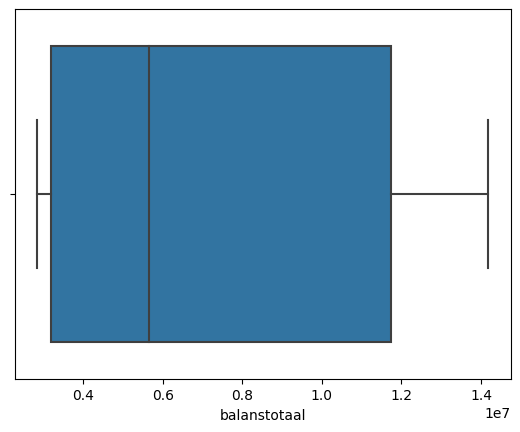

In [141]:
import seaborn as sns
sns.boxplot(data=df, x='balanstotaal')

<AxesSubplot:xlabel='omzet'>

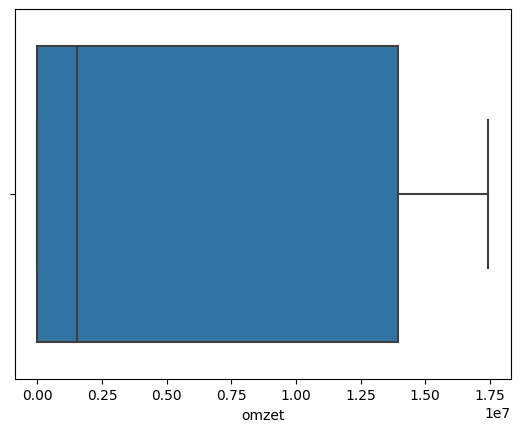

In [142]:
sns.boxplot(data=df, x='omzet')

<AxesSubplot:xlabel='personeelsbestanden'>

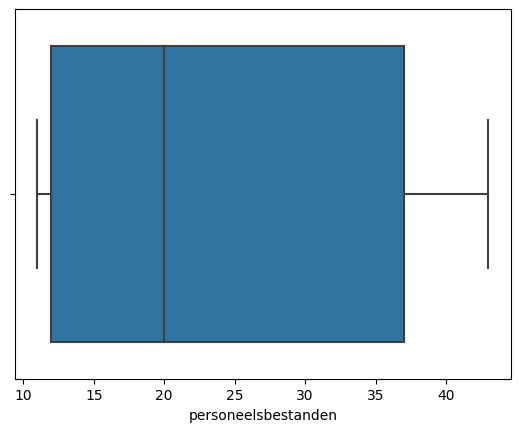

In [143]:
sns.boxplot(data=df, x='personeelsbestanden')

In [161]:
X = df.drop(['general', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df['general']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [162]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

numerical_ix = X.select_dtypes(include=['int32','int64','float64']).columns

col_transform = ColumnTransformer(transformers=[
    ('minmax',MinMaxScaler(), numerical_ix),
])

# Data-Analyse

In [163]:
df['general'].value_counts(bins=10)

(38.36, 43.77]                  717
(43.77, 49.179]                 620
(32.951, 38.36]                 540
(65.408, 70.818]                491
(49.179, 54.589]                474
(16.666999999999998, 22.132]    399
(54.589, 59.999]                382
(59.999, 65.408]                252
(27.541, 32.951]                204
(22.132, 27.541]                 83
Name: general, dtype: int64

<AxesSubplot:xlabel='general', ylabel='Count'>

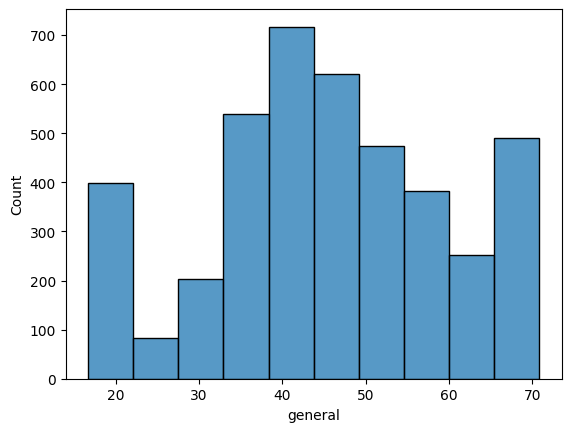

In [164]:
import seaborn as sns
sns.histplot(data=df, x='general', bins=10)

In [165]:
under_30 = df[df['general'] < 30]
under_30 = under_30.sample(n=500)
middle = df[(df['general'] >= 30) & (df['general'] <= 65)]
above_65 = df[df['general'] > 65]
above_65 = above_65.sample(n=500)

In [166]:
print(len(under_30), len(middle), len(above_65))

500 3162 500


In [167]:
df = pd.concat([under_30, middle, above_65])

<AxesSubplot:xlabel='general', ylabel='Count'>

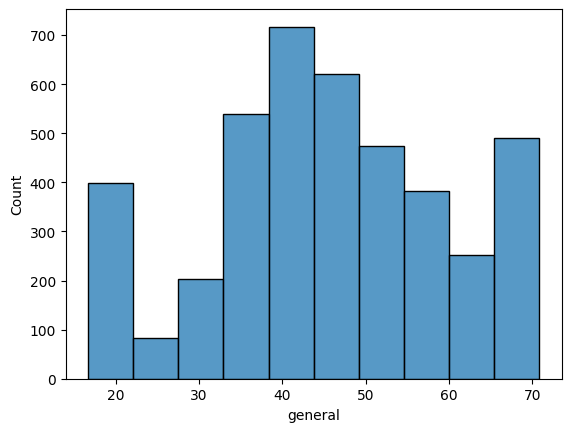

In [168]:
sns.histplot(data=df, x='general', bins=10)

# Split

In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Lineaire Regressie

In [170]:
from sklearn.linear_model import LinearRegression

# Create the model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions using the test data
predictions = model.predict(X_test)

In [171]:
predictions

array([42.2791954 , 45.75386673, 39.62031785, 48.9726605 , 52.53534647,
       41.22098287, 51.15131539, 44.017639  , 40.38152592, 51.66061107,
       39.73644065, 51.54289836, 43.69236304, 37.85864218, 55.67338132,
       46.94208916, 50.12085009, 49.4206451 , 52.30734292, 40.51880711,
       41.10342165, 50.45861959, 39.14404524, 45.55116947, 39.03267849,
       39.68395999, 38.53511153, 46.27409597, 49.72912141, 45.09504474,
       50.42294882, 51.95978349, 40.54305571, 49.58524959, 37.97990918,
       46.26922021, 42.63500234, 56.05467454, 47.75114643, 39.77313408,
       53.46770891, 42.85188512, 47.34823915, 54.55804691, 44.2722539 ,
       51.18534756, 44.46721109, 48.24123444, 55.82360472, 45.72989745,
       43.05560071, 40.61174737, 44.21548339, 54.57328689, 40.21144886,
       51.77606969, 54.24790385, 53.91014112, 42.43738728, 41.23875537,
       49.81534822, 52.19305845, 40.26133768, 41.08507978, 41.78498575,
       53.46263312, 39.49434098, 39.13379765, 56.16169079, 38.85

In [172]:
# Print the model's coefficients and intercept
print(model.coef_)
print(model.intercept_)

[2.11015770e+00 1.92399632e-07 5.62529180e-07 7.03420459e-02
 1.39576933e-01]
31.32676402701166


In [173]:
from sklearn.metrics import mean_squared_error

# Compute the MSE for the model's predictions on the test set
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

from sklearn.metrics import r2_score

# Compute the R-squared for the model's predictions on the test set
r2 = r2_score(y_test, predictions)
print(f"R²: {r2}") # --> fit helemaal niet goed!

from sklearn.metrics import mean_absolute_error

# Compute the MAE for the model's predictions on the test set
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae}")

MSE: 191.52217197637756
R²: 0.08433375313195457
MAE: 11.188768250094856


In [174]:
import pickle
from sklearn.linear_model import LinearRegression

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Save the model to a file
with open('linear-reg.pkl', 'wb') as f:
    pickle.dump(model, f)